# Desafio Tractian

1. Fazer a Análise Espectral (fft e harmônicos) da geladeira e identificar padrões entre coletas;
2. Fazer um Algoritmo que calcula automaticamente quanto tempo a geladeira ficou ligada (uptime) e quanto tempo ela ficou desligada (downtime).
3. Fazer sua análise sobre a condição do compressor da geladeira, está desbalanceado? Desalinhado? Que condição se encontra.

## Estrutura do notebook:
### 1. Análise Espectral
-Criando funções para facilitar a análise
#### a) Visualização da análise espectral das coletas 1-4
-Gráficos de FFT vs frequência
#### b) Investigação de padrões
-Gráficos de amplitude máxima por coleta
### 2. Algoritmo de Uptime e Downtime
-Função generalisada <br>
-Script para rodar o algoritmo
### 3. Análise sobre condição do compressor
a) Observações <br>
b) Conclusões <br>
c) Considerações futuras
### 4. Apêndice
a) Exploração inicial dos dados <br>
b) Checando diferença de tempo entre coletas <br>
c) Considerações futuras <br>
d) Gráficos da análise espectral (coletas 5-20)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.fft as fft
import numpy as np
import re
from os import listdir

# 1. Análise Espectral

In [2]:
def get_files_list(path):
    filenames_list = listdir(path=path)
    filenames_list.sort()
    return filenames_list

In [3]:
def load_data(num_coleta):
    '''
    Carrega os dados da coleta em um pd.DataFrame.
    
    Args:
        num_coleta = int , número da coleta (0-19)
        
    Returns:
        df = DataFrame contendo os dados x,y,z
        num_coleta = mesmo índice de coleta. Facilita uso de outros métodos mais para a frente
    '''
    
    path_root = "./data/Coletas-Geladeira/"
    filenames_list = get_files_list(path_root)
    file_name = filenames_list[num_coleta]

    path = path_root + file_name
    
    df = pd.read_csv(path, header=None)
    df.columns = ["x","y","z","C"]
    df.drop(columns="C",inplace=True)
    return df, num_coleta

In [4]:
def get_fft(df,num_coleta):
    '''
    Recebe os dados do acelerômetro em m/s^2 e aplica o FFT

    Args:
        df = DataFrame contendo dados de x,y,z
        num_coleta = int , número da coleta (0-19)

    Returns:
        fft_df = DataFrame com dados de FFT para os eixos x,y,z e a frequência em que ocorrem
    '''
    x_signal,y_signal,z_signal = df['x'], df['y'], df['z']

    # Subtraindo a média para tirar o pico na frequencia 0Hz
    x_signal -= x_signal.mean()
    y_signal -= y_signal.mean()
    z_signal -= z_signal.mean()

    # Aplicando FFT
    x_fft = np.abs(fft.fft(x=np.array(x_signal)))
    y_fft = np.abs(fft.fft(x=np.array(y_signal)))
    z_fft = np.abs(fft.fft(x=np.array(z_signal)))

    # Gerando frequências para o FFT
    # Aproximação do espaçamento entre amostras -> Coleta de 60s / ~12700 amostras por coleta
    sample_spacing = 60/12700
    freq = np.abs(fft.fftfreq(x_fft.size, sample_spacing))

    # Criando DataFrame com os resultados
    fft_df = pd.DataFrame({"freq":freq, "x_fft":x_fft, "y_fft":y_fft, "z_fft":z_fft})
    
    return fft_df

def custom_round(x, base=2):
    return int(base * round(float(x)/base))

def get_top_values(fft_df, num_peaks=5):
    '''
    Retorna as maiores amplitudes e frequências na quais elas ocorrem em seus respectivos eixos.

    Args:
        fft_df = DataFrame com dados de FFT para os eixos x,y,z e a frequência em que ocorrem
        num_peaks = int, default=5, números de picos de amplitude desejado

    Returns:
        top_value_x = DataFrame contendo amplitude e frequências mais altas no eixo x
        top_value_y = DataFrame contendo amplitude e frequências mais altas no eixo y
        top_value_z = DataFrame contendo amplitude e frequências mais altas no eixo z
    '''
    fft_df['freq'] = fft_df['freq'].apply(lambda x: custom_round(x, base=2))

    top_values_x = fft_df[['freq','x_fft']].copy()
    top_values_x = top_values_x.groupby(by='freq', group_keys=False, as_index=False).apply(lambda x: x.loc[x.x_fft.idxmax()])
    top_values_x = top_values_x.sort_values(by='x_fft', ascending=False)

    top_values_y = fft_df[['freq','y_fft']].copy()
    top_values_y = top_values_y.groupby(by='freq', group_keys=False, as_index=False).apply(lambda x: x.loc[x.y_fft.idxmax()])
    top_values_y = top_values_y.sort_values(by='y_fft', ascending=False)

    top_values_z = fft_df[['freq','z_fft']].copy()
    top_values_z = top_values_z.groupby(by='freq', group_keys=False, as_index=False).apply(lambda x: x.loc[x.z_fft.idxmax()])
    top_values_z = top_values_z.sort_values(by='z_fft', ascending=False)

    return top_values_x.head(num_peaks), top_values_y.head(num_peaks), top_values_z.head(num_peaks) 

In [5]:
def plot_fft(df,num_coleta):
    
    # Calcula FFTs e gera um DataFrame com frequência e FFT
    fft_df = get_fft(df,num_coleta)
    
    # Configurando a figura e os eixos para fazer o plot
    fig = plt.figure(figsize=(15, 15))
    custom_xlim = (0, fft_df.freq.max())
    custom_ylim = (0, 8000)
    fig.suptitle(f'Coleta #{num_coleta + 1}', fontsize=16)
    ax1 = fig.add_subplot(3,1,1)
    ax2 = fig.add_subplot(3,1,2)
    ax3 = fig.add_subplot(3,1,3)
    plt.setp([ax1,ax2,ax3], xlim=custom_xlim, ylim=custom_ylim)
    
    # Fazendo o plot de frequência vs amplitude 
    ax1.plot(fft_df.freq, fft_df.x_fft)
    ax2.plot(fft_df.freq, fft_df.y_fft)
    ax3.plot(fft_df.freq, fft_df.z_fft)
    
    # Configurando os gráficos 
    ax1.title.set_text('X FFT')
    ax2.title.set_text('Y FFT')
    ax3.title.set_text('Z FFT')
    ax1.set_ylabel('Amplitude')
    ax2.set_ylabel('Amplitude')
    ax3.set_ylabel('Amplitude')
    ax3.set_xlabel('Frequency')

In [6]:
df,num = load_data(0)
fft_df = get_fft(df,num)
fft_df

,freq,x_fft,y_fft,z_fft
0,0.000000,4.222400e-12,5.613288e-13,1.877609e-12
1,0.016631,3.992065e+00,1.299699e+01,1.018317e+01
2,0.033263,1.633513e+00,1.507867e+01,1.702465e+01
3,0.049894,1.144385e+01,3.078550e+01,4.878946e+00
4,0.066525,9.025176e+00,3.245849e+01,4.536379e+01
...,...,...,...,...
12722,0.083157,1.039796e+01,1.835829e+01,1.806877e+01
12723,0.066525,9.025176e+00,3.245849e+01,4.536379e+01
12724,0.049894,1.144385e+01,3.078550e+01,4.878946e+00
12725,0.033263,1.633513e+00,1.507867e+01,1.702465e+01


In [7]:
top_values_x, top_values_y, top_values_z = get_top_values(fft_df,10)
top_values_x

,freq,x_fft
20,40.0,2336.132939
1,2.0,382.357769
40,80.0,273.876673
21,42.0,173.635625
18,36.0,148.230928
47,94.0,121.016884
45,90.0,104.513232
42,84.0,85.271653
38,76.0,75.541369
27,54.0,73.344533


## 1. a) Análise Espectral das coletas
-Coletas 1-4 exibidas como amostra <br>
-Gráficos para as demais no final do notebook

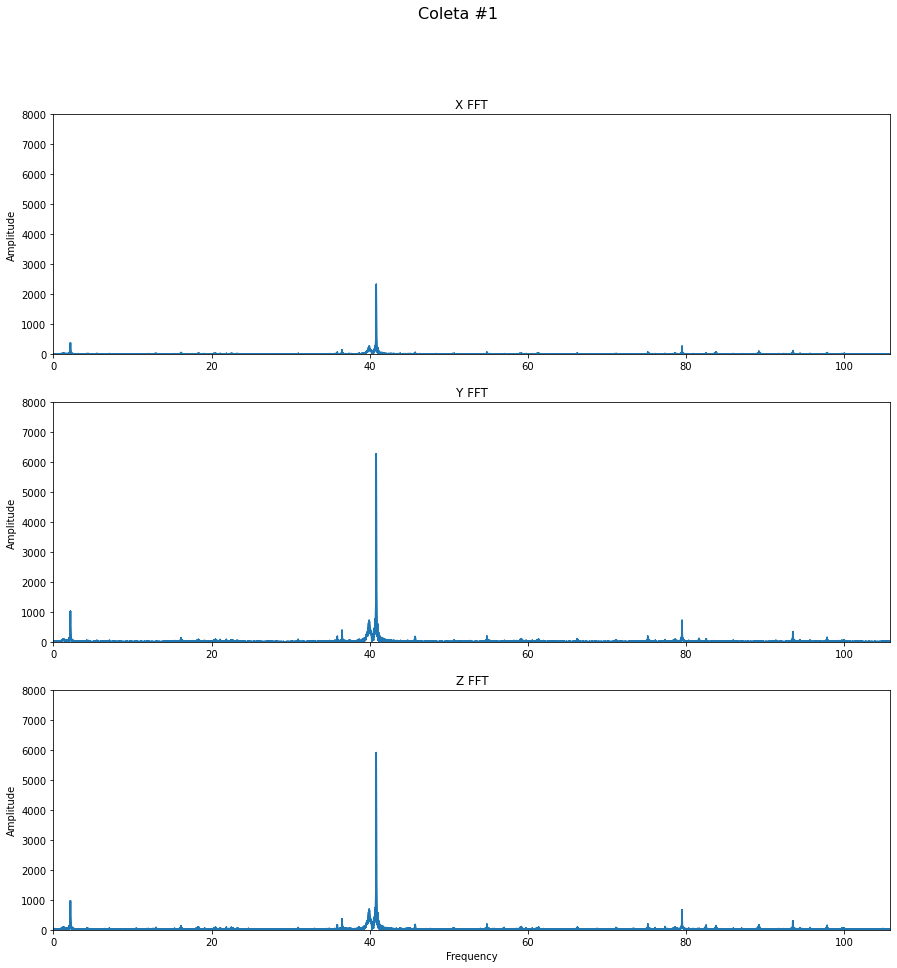

In [8]:
# Coleta 1
df,num = load_data(0)
plot_fft(df,num)

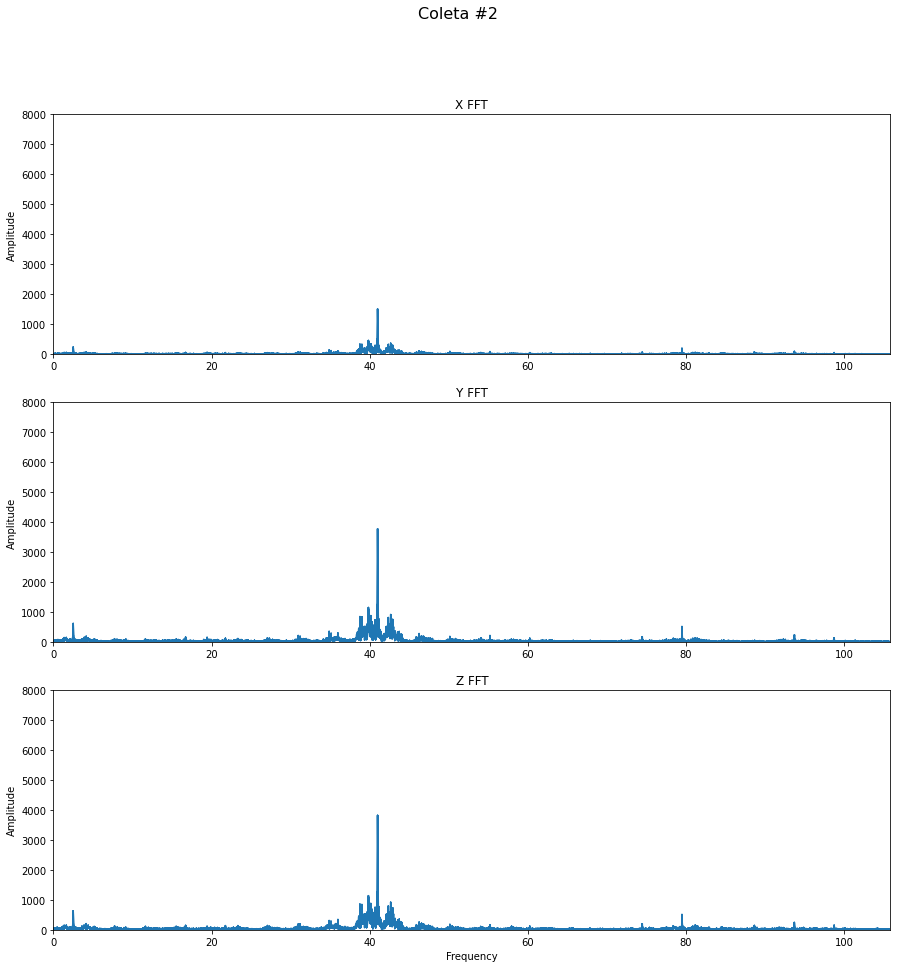

In [9]:
# Coleta 2
df,num = load_data(1)
plot_fft(df,num)

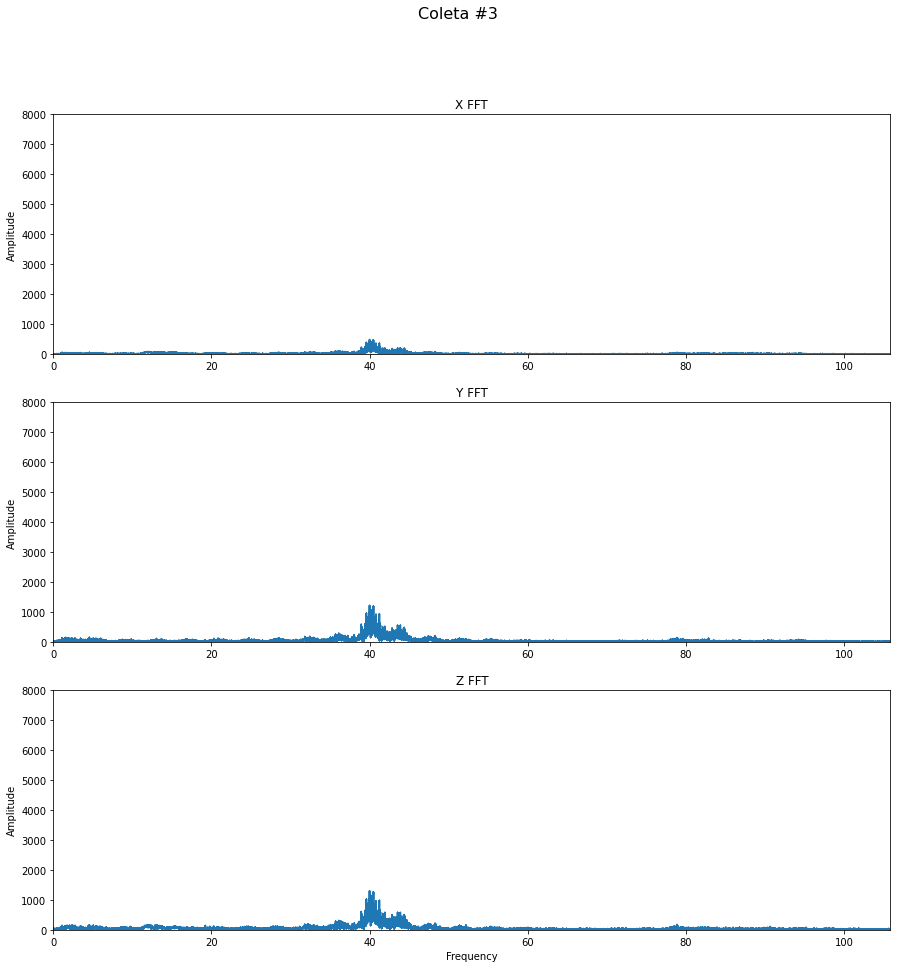

In [10]:
# Coleta 3
df,num = load_data(2)
plot_fft(df,num) 

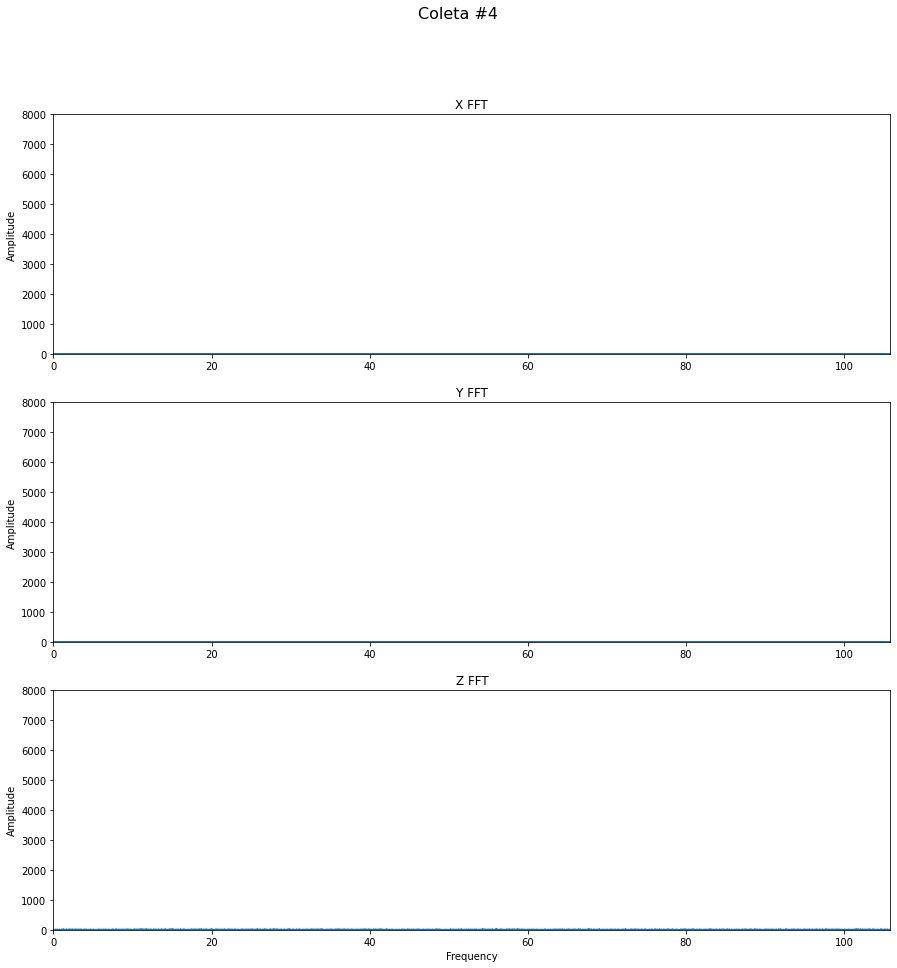

In [11]:
# Coleta 4
df,num = load_data(3)
plot_fft(df,num) 

## 1. b) Investigação de Padrões
-Investigando variância de amplitude máxima por coleta

In [12]:
path = "./data/Coletas-Geladeira/"
num_coletas_total = len(get_files_list(path))

max_amp_x = []
max_amp_y = []
max_amp_z = []
max_freq_x = []
max_freq_y = []
max_freq_z = []
num_coleta_list = []

for num_coleta in range(num_coletas_total):
    df,num = load_data(num_coleta)
    fft_df = get_fft(df,num_coleta)
    top_values_x, top_values_y, top_values_z = get_top_values(fft_df,1)
    
    max_amp_x.append(top_values_x.loc[top_values_x.index[0],'x_fft'])
    max_amp_y.append(top_values_y.loc[top_values_y.index[0],'y_fft'])
    max_amp_z.append(top_values_z.loc[top_values_z.index[0],'z_fft'])
    num_coleta_list.append(num_coleta)
    
    max_freq_x.append(top_values_x.loc[top_values_x.index[0],'freq'])
    max_freq_y.append(top_values_y.loc[top_values_y.index[0],'freq'])
    max_freq_z.append(top_values_z.loc[top_values_z.index[0],'freq'])

Text(0.5, 0, 'Coleta')

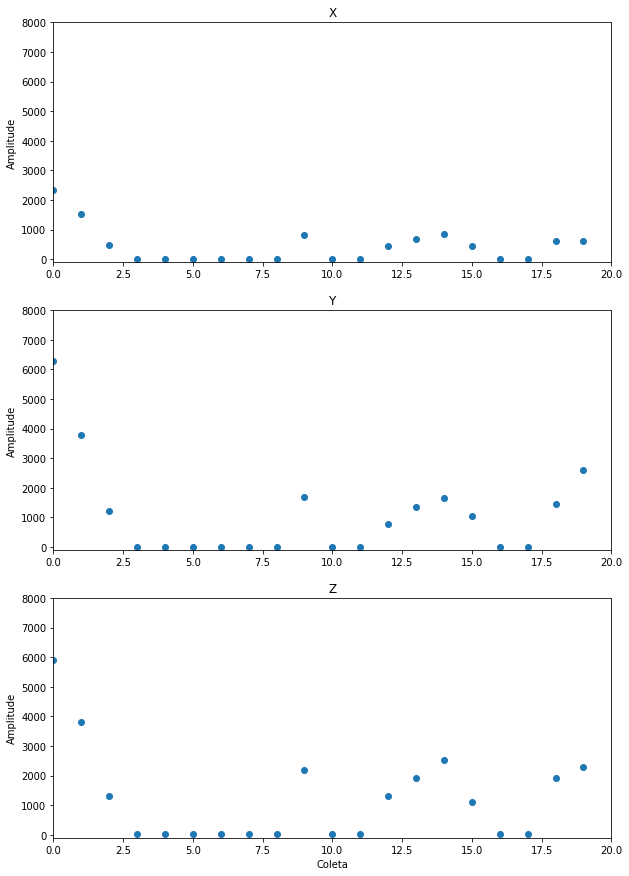

In [13]:
fig = plt.figure(figsize=(10, 15))
ax4 = fig.add_subplot(3,1,1)
ax5 = fig.add_subplot(3,1,2)
ax6 = fig.add_subplot(3,1,3)

custom_xlim = (0, 20)
custom_ylim = (-100, 8000)
plt.setp([ax4,ax5,ax6], xlim=custom_xlim, ylim=custom_ylim)

ax4.scatter(num_coleta_list, max_amp_x)
ax5.scatter(num_coleta_list, max_amp_y)
ax6.scatter(num_coleta_list, max_amp_z)
ax4.title.set_text('X')
ax5.title.set_text('Y')
ax6.title.set_text('Z')
ax4.set_ylabel('Amplitude')
ax5.set_ylabel('Amplitude')
ax6.set_ylabel('Amplitude')
ax6.set_xlabel('Coleta')

# 2. Algoritmo de Uptime & Downtime

In [14]:
def get_epochs(filename):
    '''
    
    Takes filename as str, separates into start and end epochs. Then, converts from str to int.
    Returns list of ints as [start_epoch, end_epoch]
    '''
    reg_ex = "\d+"
    epochs_str = re.findall(reg_ex,filename)
    
    epochs_int = []
    for e_str in epochs_str:
        epochs_int.append(int(e_str))
        
    return epochs_int

def get_current_state(num_coleta, threshold=150):
    '''Takes filename, returns True for machine on and False for machine off'''
    df, num_coleta = load_data(num_coleta)
    fft_df = get_fft(df,num_coleta)
    top_values_x, top_values_y, top_values_z = get_top_values(fft_df,1)    
    
    x_condition = top_values_x.loc[top_values_x.index[0],'x_fft'] > threshold
    y_condition = top_values_y.loc[top_values_y.index[0],'y_fft'] > threshold
    z_condition = top_values_z.loc[top_values_z.index[0],'z_fft'] > threshold
    if x_condition | y_condition | z_condition:
        return True
    else:
        return False
    
def get_total_uptime(path):
    num_files = len(get_files_list(path))
    
    total_uptime = 0
    for i in range(num_files):
        current_state = get_current_state(i)
        if current_state:
            total_uptime += 1
    
    return total_uptime

def get_total_downtime(path):
    num_files = len(get_files_list(path))
    
    total_downtime = 0
    for i in range(num_files):
        current_state = get_current_state(i)
        if not current_state:
            total_downtime += 1
    
    return total_downtime

In [17]:
path = "./data/Coletas-Geladeira/"
total_uptime = get_total_uptime(path)
total_downtime = get_total_downtime(path)

print(f"Total Uptime: {total_uptime}")
print(f"Total Downtime: {total_downtime}")

Total Uptime: 10
Total Downtime: 10


# 3. Análise sobre condição do compressor da geladeira
### a) Observações

1. Primeiras observações: <br>
-Dados de aceleração não estavam centrados no 0, o que sugere viés de voltagem ("DC voltage bias"). Portanto, o primeiro pico de amplitude foi filtrado antes do FFT. <br>
-Analisando o Fourier Transform das primeiras 3 coletas, vemos um pico nítido por volta dos 40Hz. Esse padrão parece se repetir para as demais coletas, embora com magnitudes diferentes. <br>
-Aprofundando mais, vemos que esse pico se repete nos múltiplos dessa frequência (2, 40, 80Hz). Isso sugere a presença de harmônicos <br>

2. Observações mais aprofundadas: <br>
-Utilizando o gráfico 1.b), conseguimos perceber algumas informações. Primeiro, vemos que a magnitude das vibrações no eixo Y é maior do que a do eixo Z, que por sua vez é maior do que a do eixo X.  <br>
-Vemos que a magnitude das vibrações também foi maior durante as primeiras coletas. Não só isso, como a presença de harmônicos nas demais coletas parecem neglígiveis <br>

3. Uptime & Downtime: <br>
-Tempo de uptime & downtime foi 10 horas cada <br>


### b) Conclusões

-A presença do grande pico na frequência de 40 Hz em conjunto com os harmônicos, acredito que o compressor esteja desbalanceado com maior efeito nos eixos Y e Z. <br>

### c) Considerações futuras

-Dado mais tempo para estudar a ciência por trás de tudo, acredito que seria pertinente investigar mais aprofundo a correlação entre o uptime e downtime. Especificamente, a relação entre amplitude e uptime consecutivo Uma exploração inicial se encontra no apêndice. <br>
-Seria interessante investigar o motivo pelo qual as vibrações foram mais fortes durante as coletas iniciais. Duas hipoteses são que o compressor tenha estado ligado por bastante tempo antes da coleta inicial do desafio, ou que como um carro dando partida, o compressor pode ter vibrado mais forte enquanto ligava pela primeira vez. <br>
-Para uma análise mais robusta, mais dados, como a velocidade de funcionamento da máquina.

# 4. Apêndice

## a) Exploração dos dados

-Primeira Coleta: Verificando se dados são cíclicos

Text(0.5, 1.0, 'Coleta #1: eixo X')

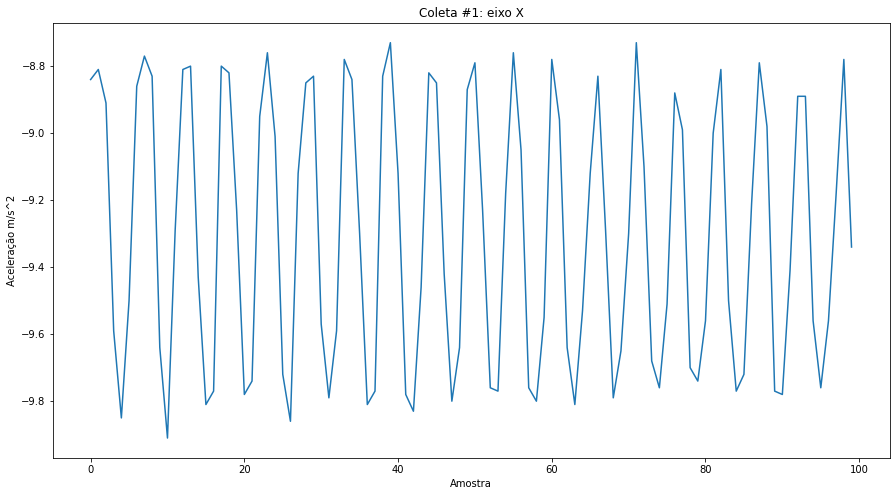

In [36]:
df_1,num = load_data(0)

fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)

plt.plot(df_1['x'].head(100))
plt.xlabel('Amostra')
plt.ylabel('Aceleração m/s^2')
plt.title('Coleta #1: eixo X')

-Segunda Coleta

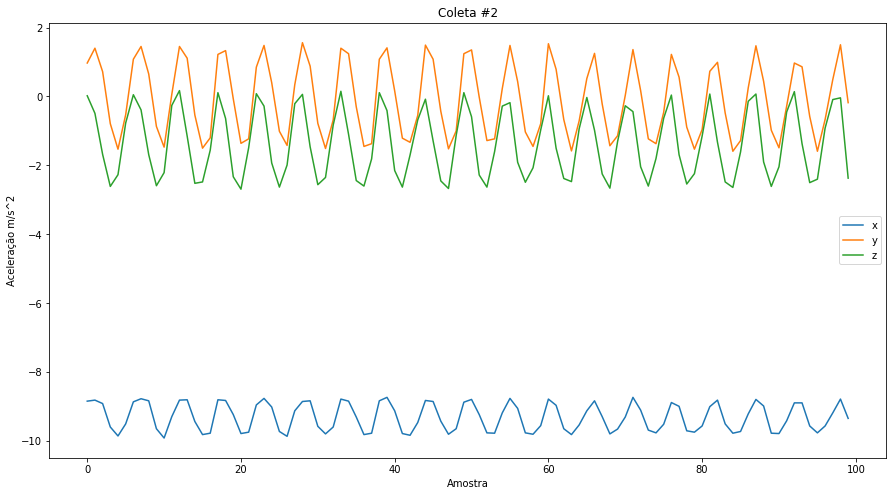

In [39]:
df_2,num = load_data(1)

fig_dims = (15, 8)
fig, ax = plt.subplots(figsize=fig_dims)

plt.plot(df_1.head(100))
plt.xlabel('Amostra')
plt.ylabel('Aceleração m/s^2')
plt.title('Coleta #2')
plt.legend(['x','y','z'],loc='right')

## b) Checando diferença de tempo entre coletas
-Diferença deve ser de ~3600s ~= 1 hora
-Verificar se há alguma coleta faltando -> tempo entre coletas disponíveis seria mais do que 1 hora 

In [41]:
col = coleta_df.loc[: , ["start epoch","end epoch"]]

difference = col.diff(axis=0)
difference

,start epoch,end epoch
0,NaN,NaN
1,3676.0,3685.0
2,3671.0,3685.0
3,3685.0,3683.0
4,3694.0,3695.0
5,3684.0,3684.0
6,3684.0,3683.0
7,3687.0,3688.0
8,3685.0,3684.0
9,3683.0,3683.0


## c) Considerações futuras

In [40]:
coleta_df = pd.DataFrame()
coleta_df["file_name"] = get_files_list(path)

list_ = []
for file in coleta_df["file_name"]:
    list_.append(get_epochs(file))

coleta_df[["start epoch","end epoch"]] = list_
coleta_df['collection time'] = coleta_df['end epoch'] - coleta_df['start epoch']
coleta_df["on_or_off"] = False

for num in range(len(list_)):
    coleta_df.loc[num,"on_or_off"] = get_current_state(num)

coleta_df["count"] = coleta_df.groupby(by="on_or_off").cumcount()
coleta_df

,file_name,start epoch,end epoch,collection time,on_or_off,count
0,1589679298-1589679343.csv,1589679298,1589679343,45,True,0
1,1589682974-1589683028.csv,1589682974,1589683028,54,True,1
2,1589686645-1589686713.csv,1589686645,1589686713,68,True,2
3,1589690330-1589690396.csv,1589690330,1589690396,66,False,0
4,1589694024-1589694091.csv,1589694024,1589694091,67,False,1
5,1589697708-1589697775.csv,1589697708,1589697775,67,False,2
6,1589701392-1589701458.csv,1589701392,1589701458,66,False,3
7,1589705079-1589705146.csv,1589705079,1589705146,67,False,4
8,1589708764-1589708830.csv,1589708764,1589708830,66,False,5
9,1589712447-1589712513.csv,1589712447,1589712513,66,True,3


## d) Gráficos de Análise Espectral

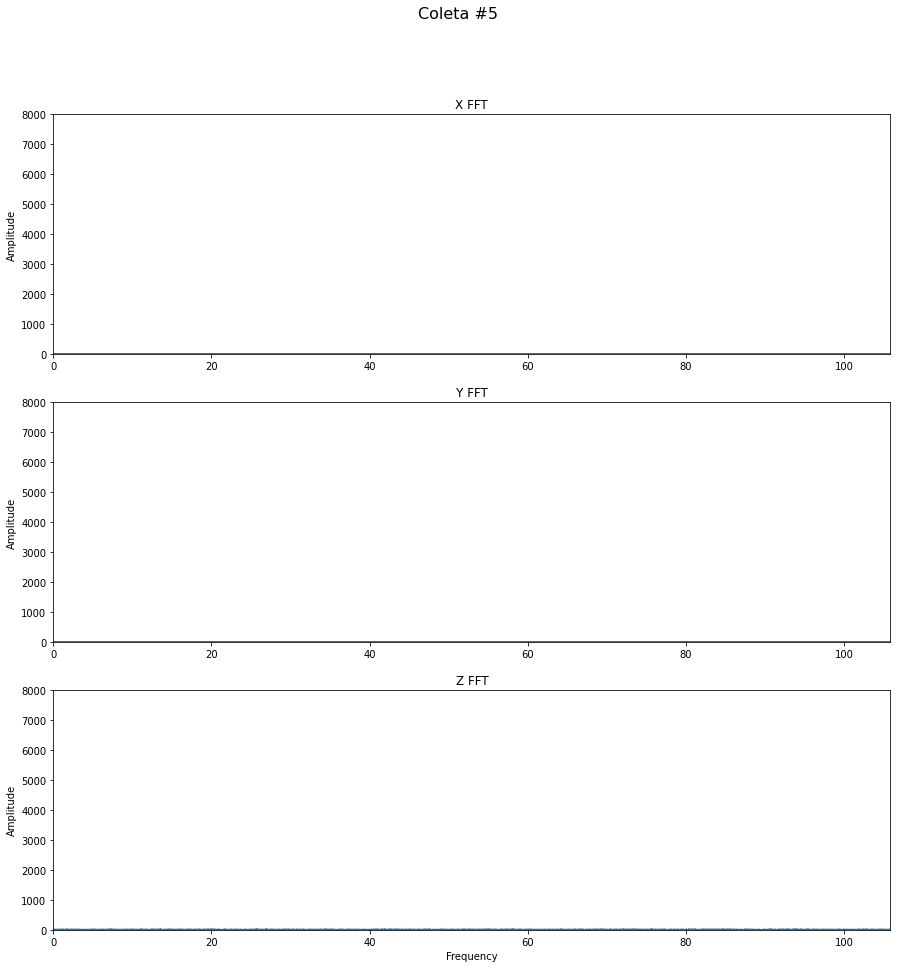

In [42]:
df,num = load_data(4)
plot_fft(df,num) 

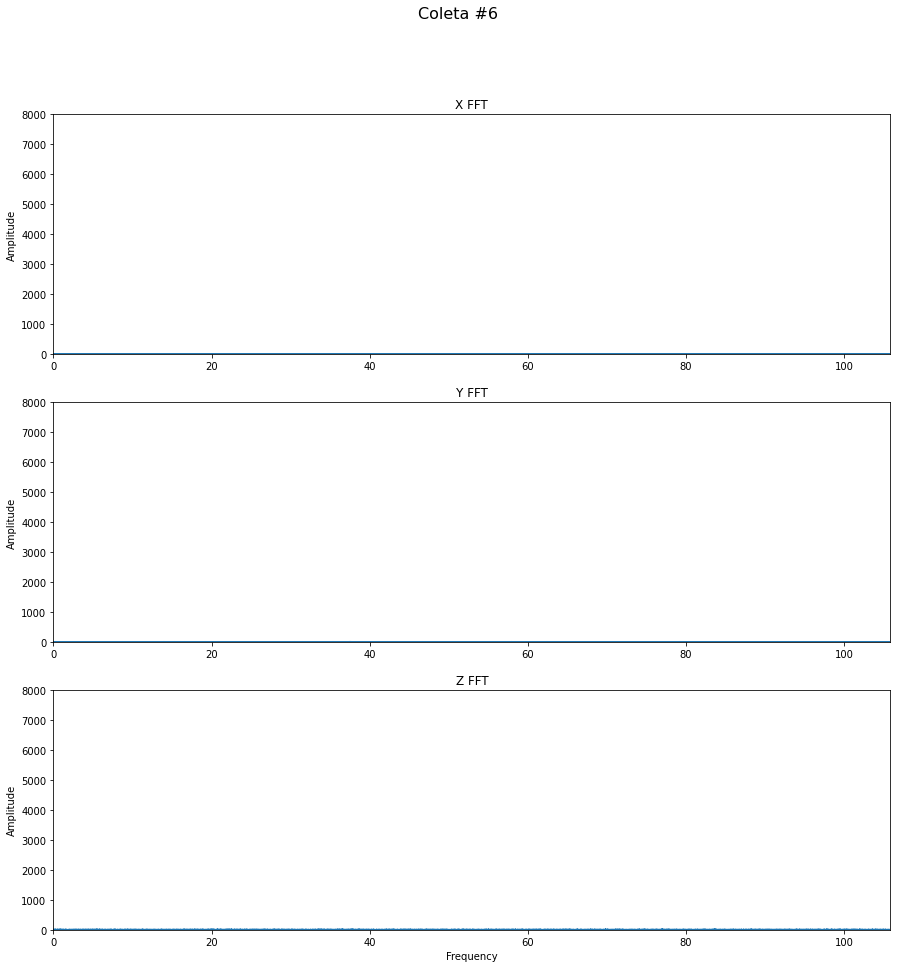

In [43]:
df,num = load_data(5)
plot_fft(df,num) 

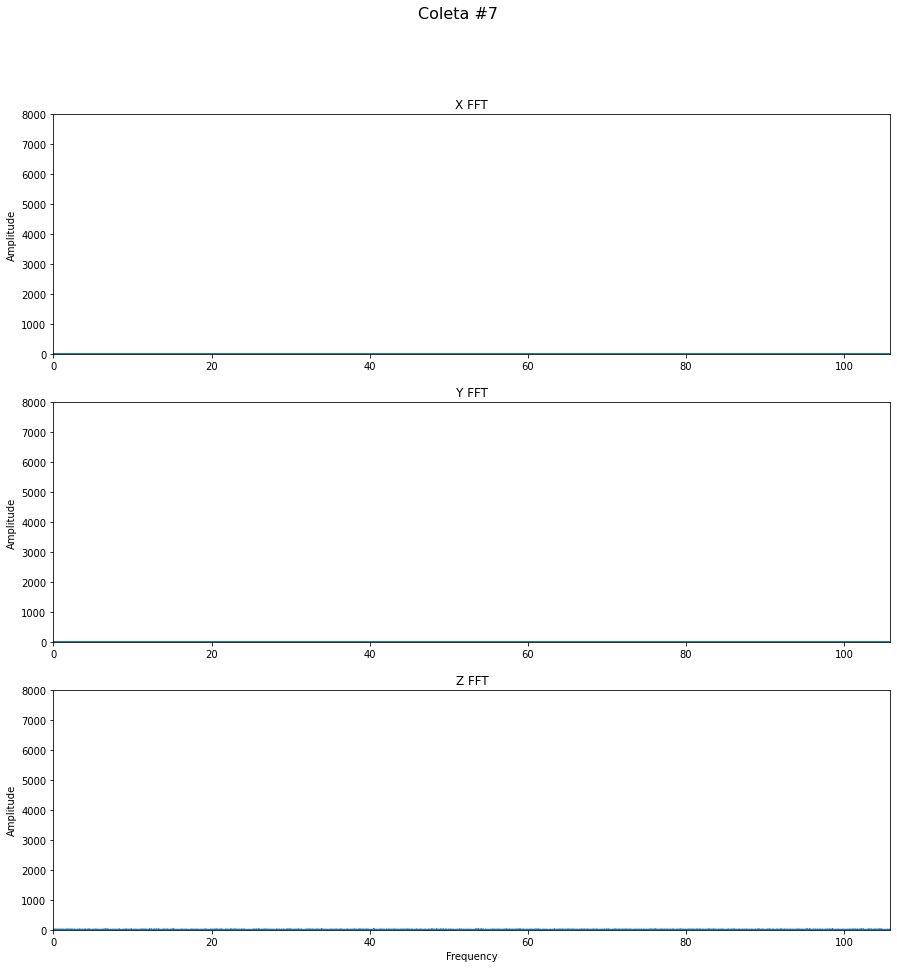

In [44]:
df,num = load_data(6)
plot_fft(df,num) 

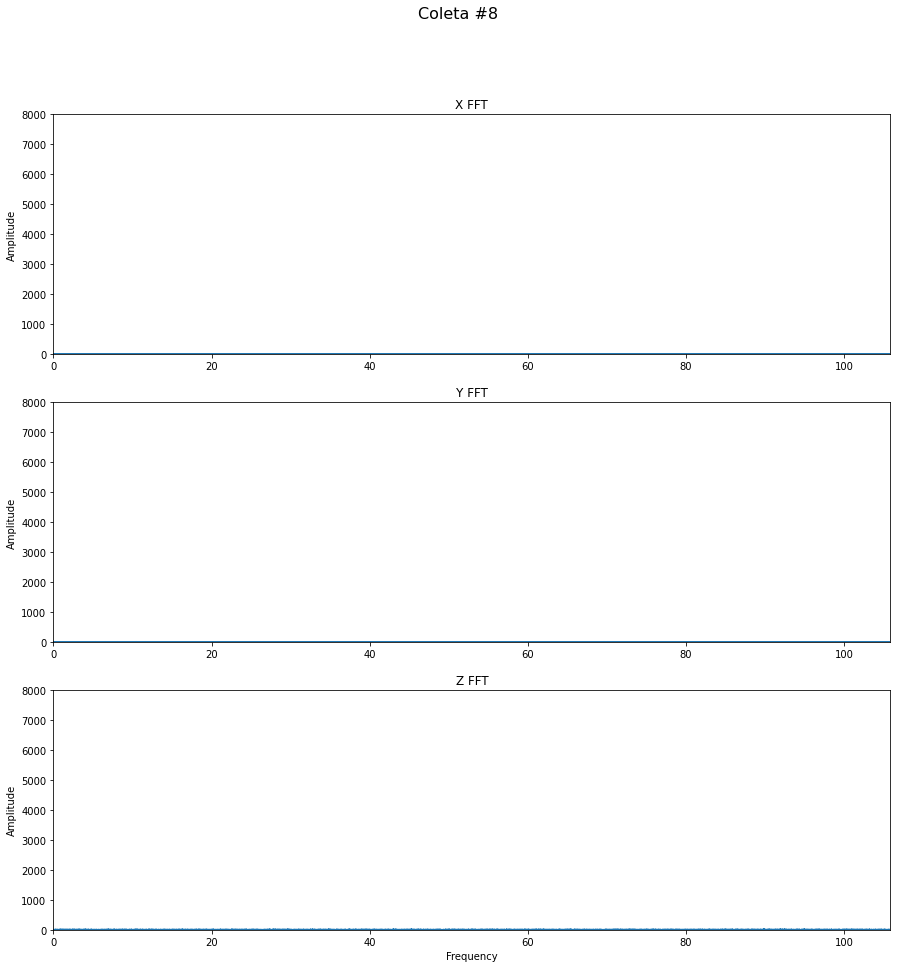

In [45]:
df,num = load_data(7)
plot_fft(df,num) 

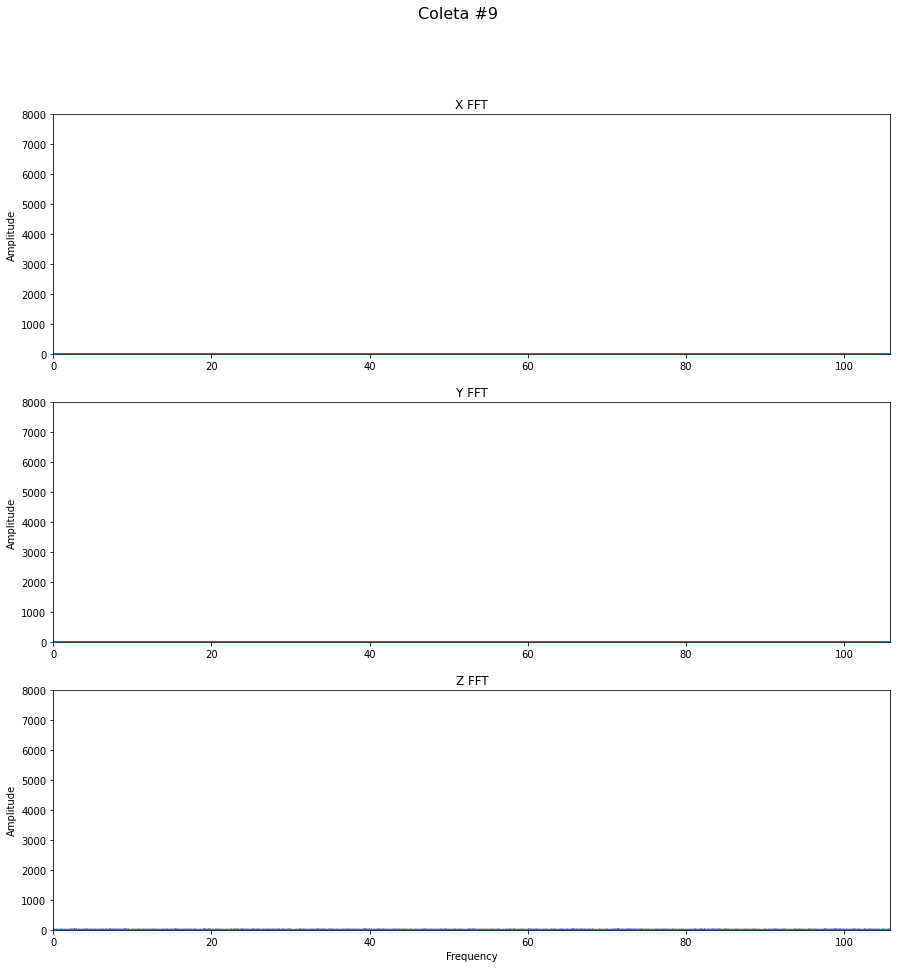

In [46]:
df,num = load_data(8)
plot_fft(df,num) 

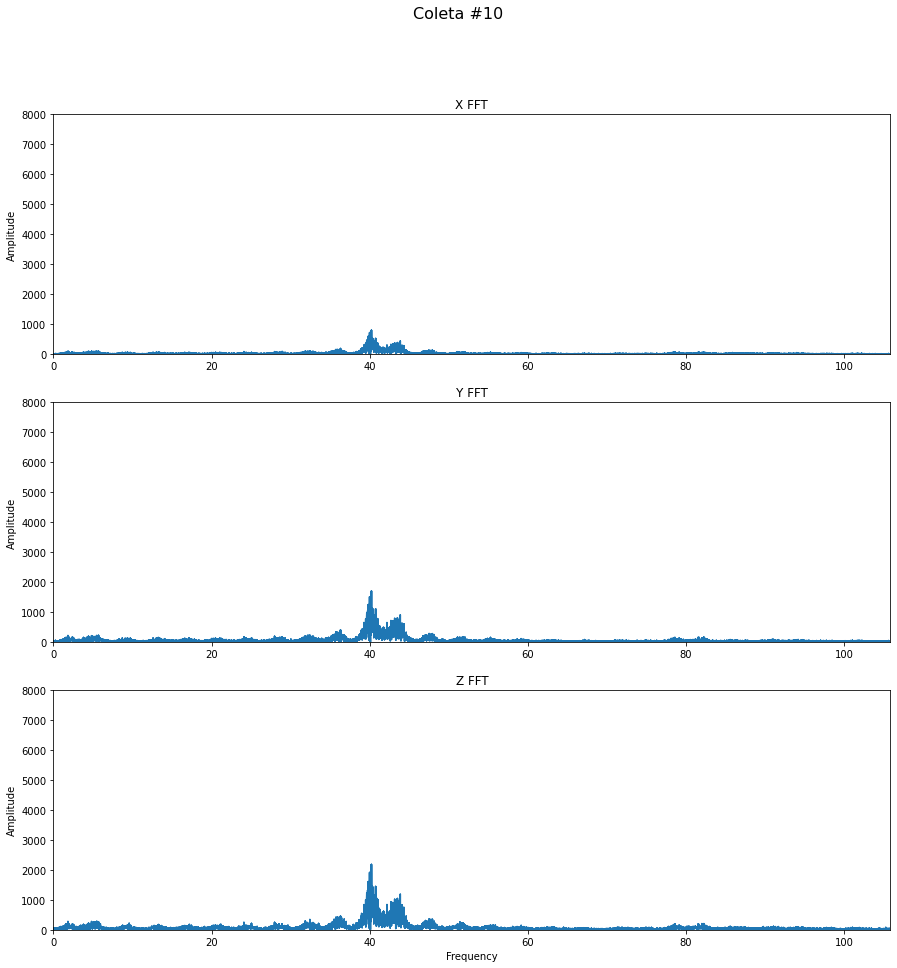

In [47]:
df,num = load_data(9)
plot_fft(df,num) 

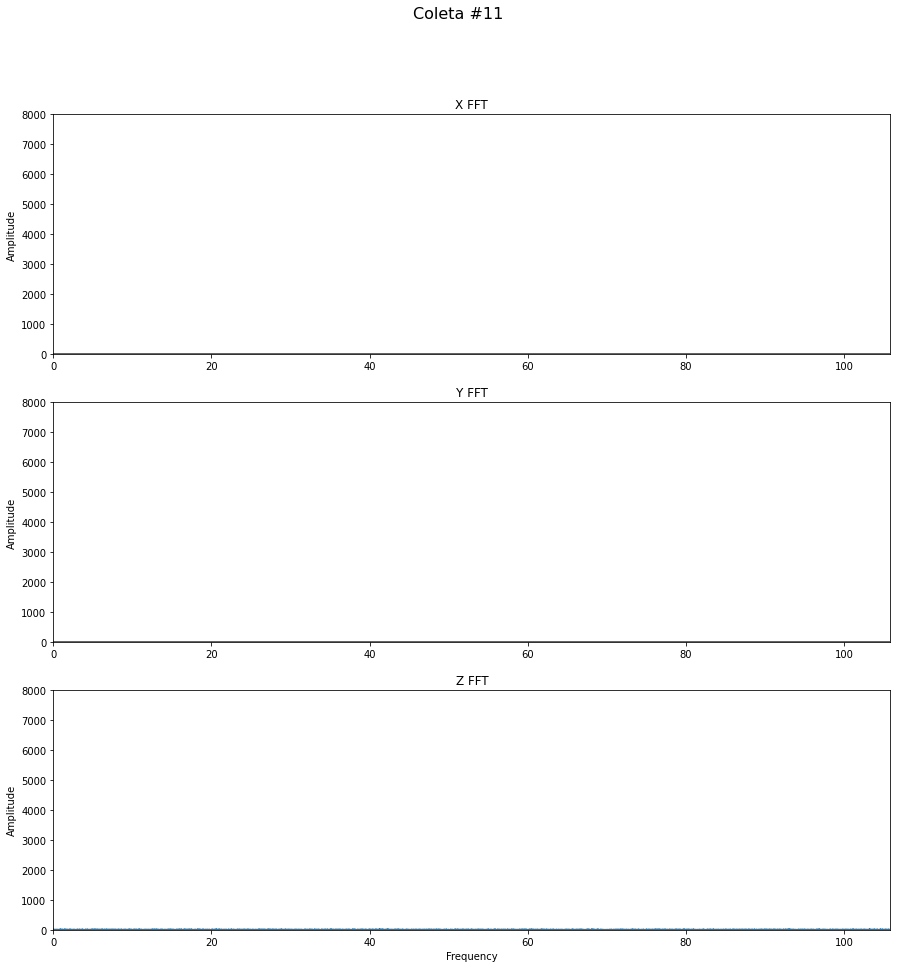

In [48]:
df,num = load_data(10)
plot_fft(df,num) 

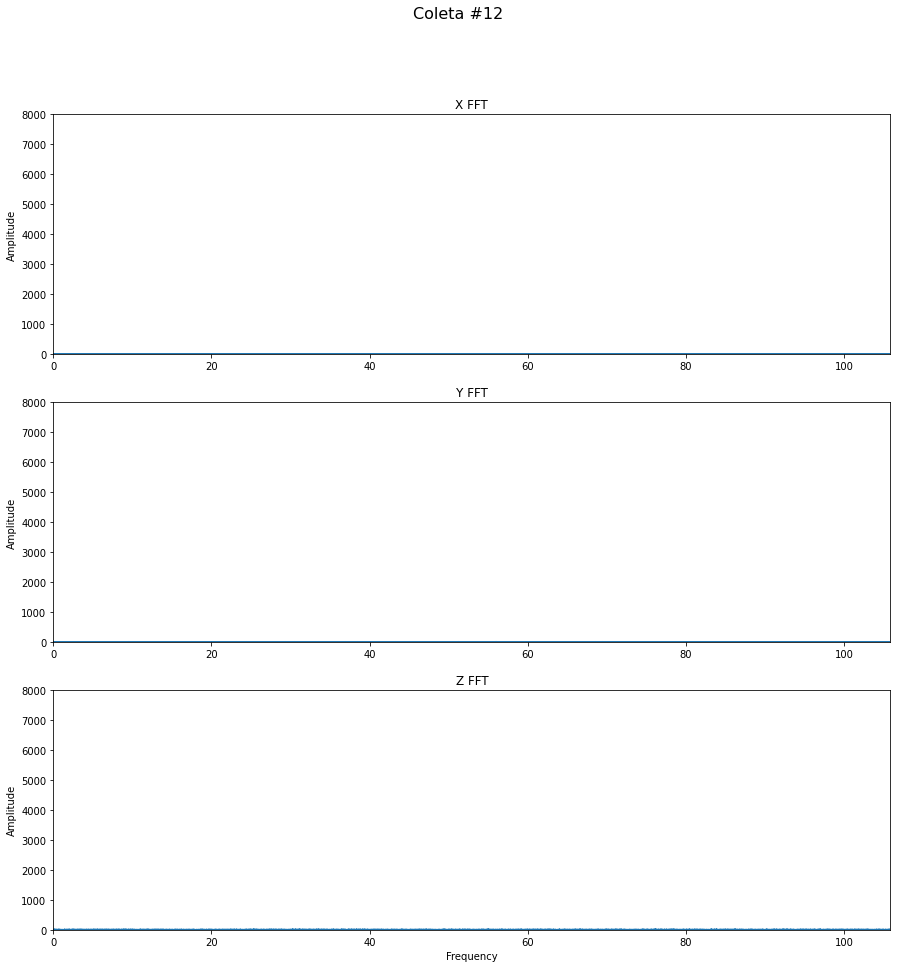

In [49]:
df,num = load_data(11)
plot_fft(df,num) 

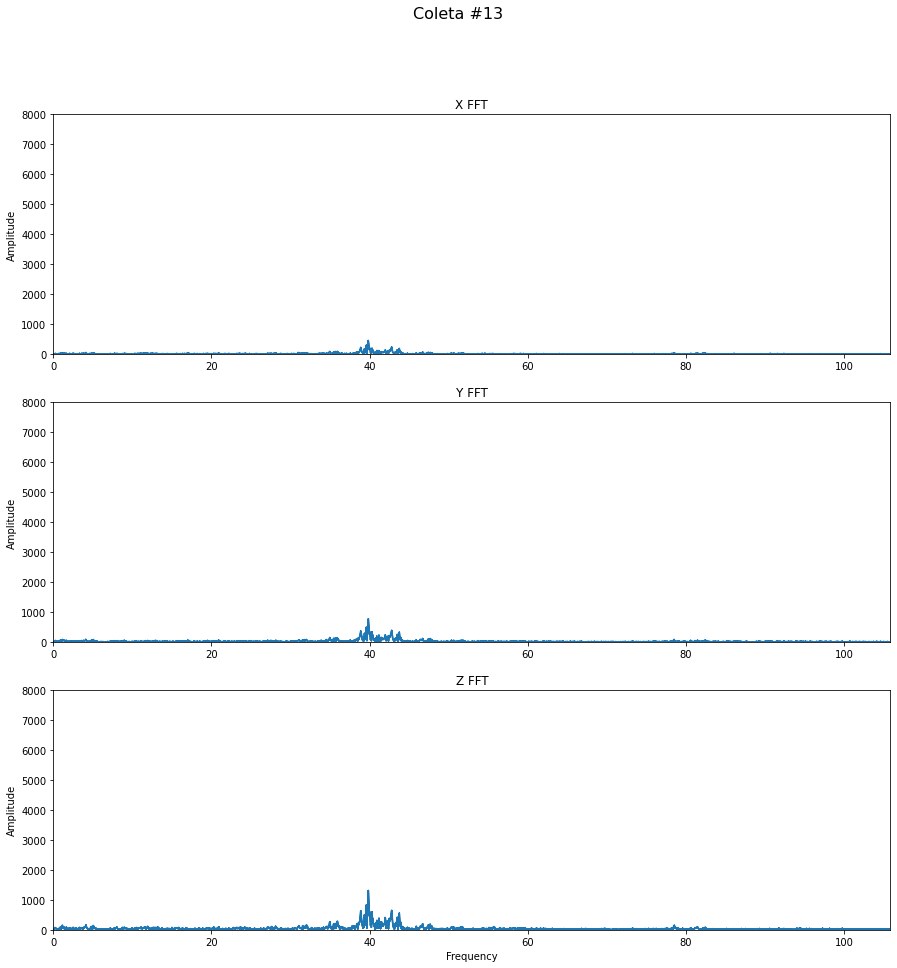

In [50]:
df,num = load_data(12)
plot_fft(df,num) 

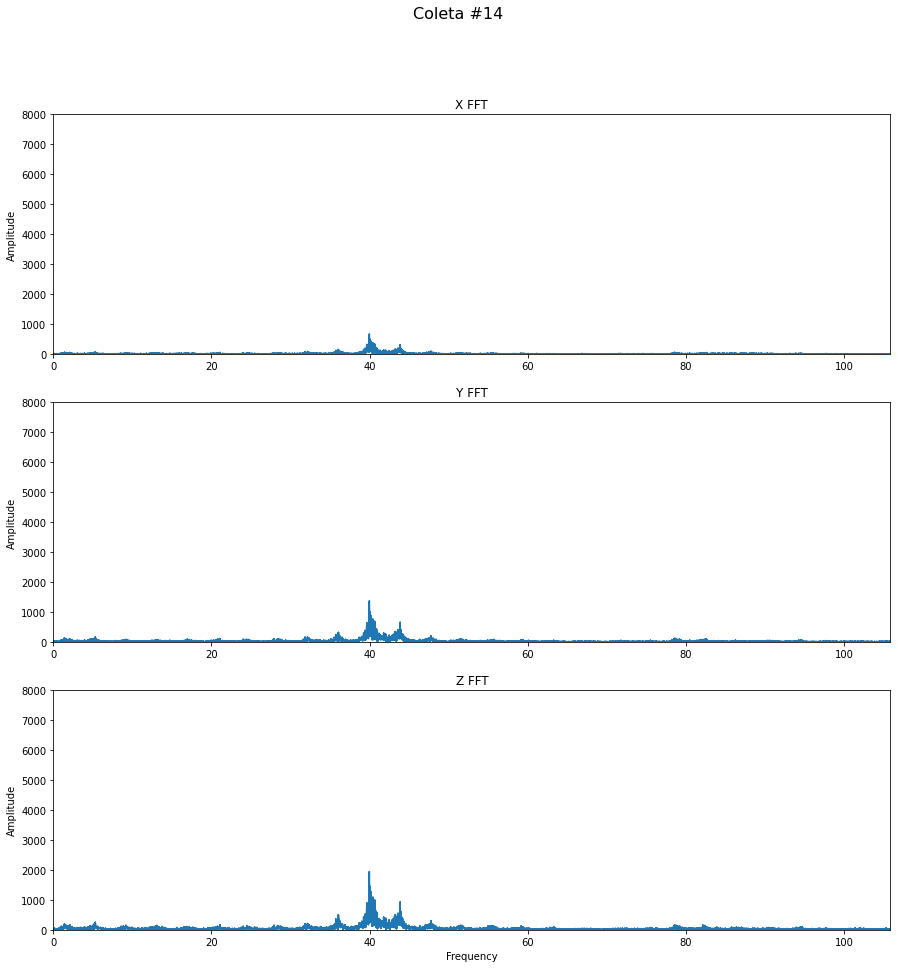

In [51]:
df,num = load_data(13)
plot_fft(df,num) 

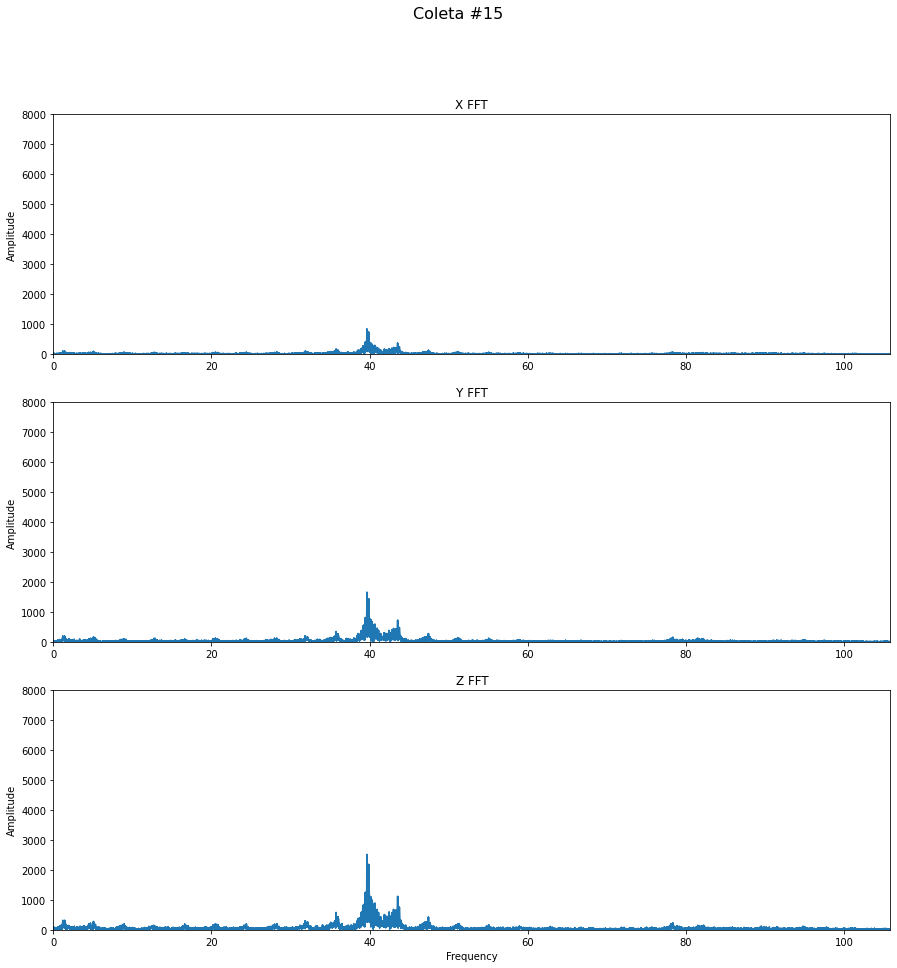

In [52]:
df,num = load_data(14)
plot_fft(df,num) 

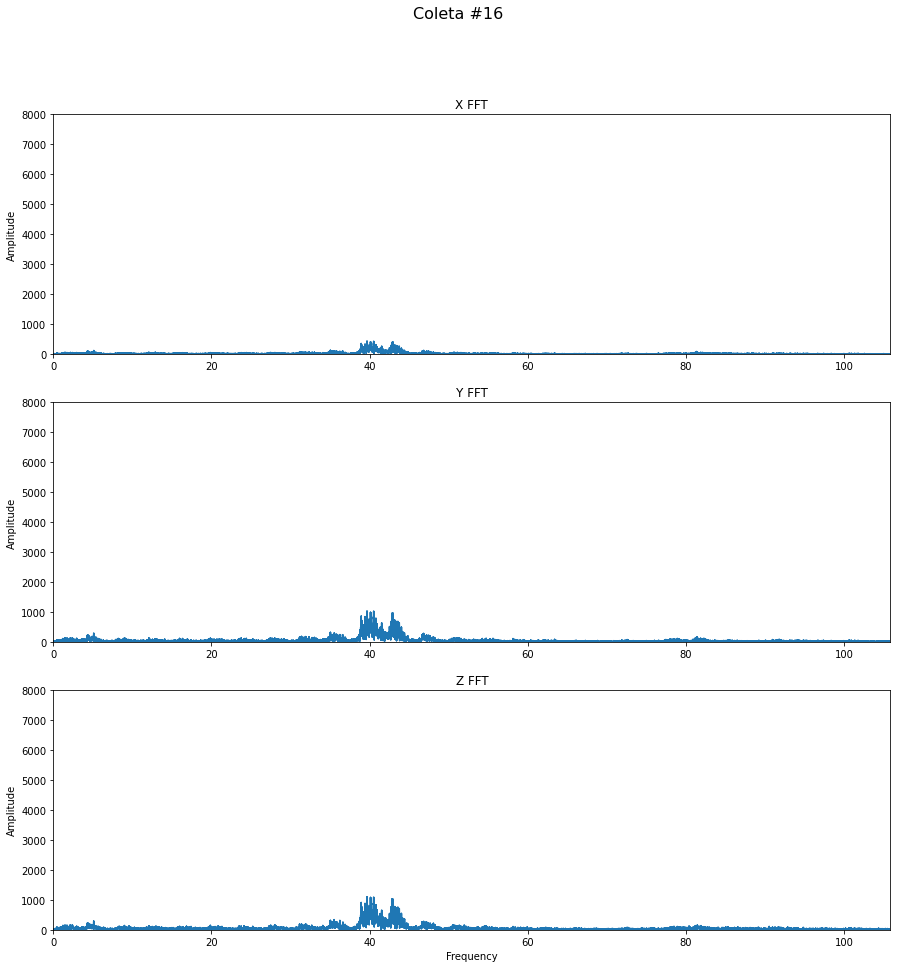

In [53]:
df,num = load_data(15)
plot_fft(df,num) 

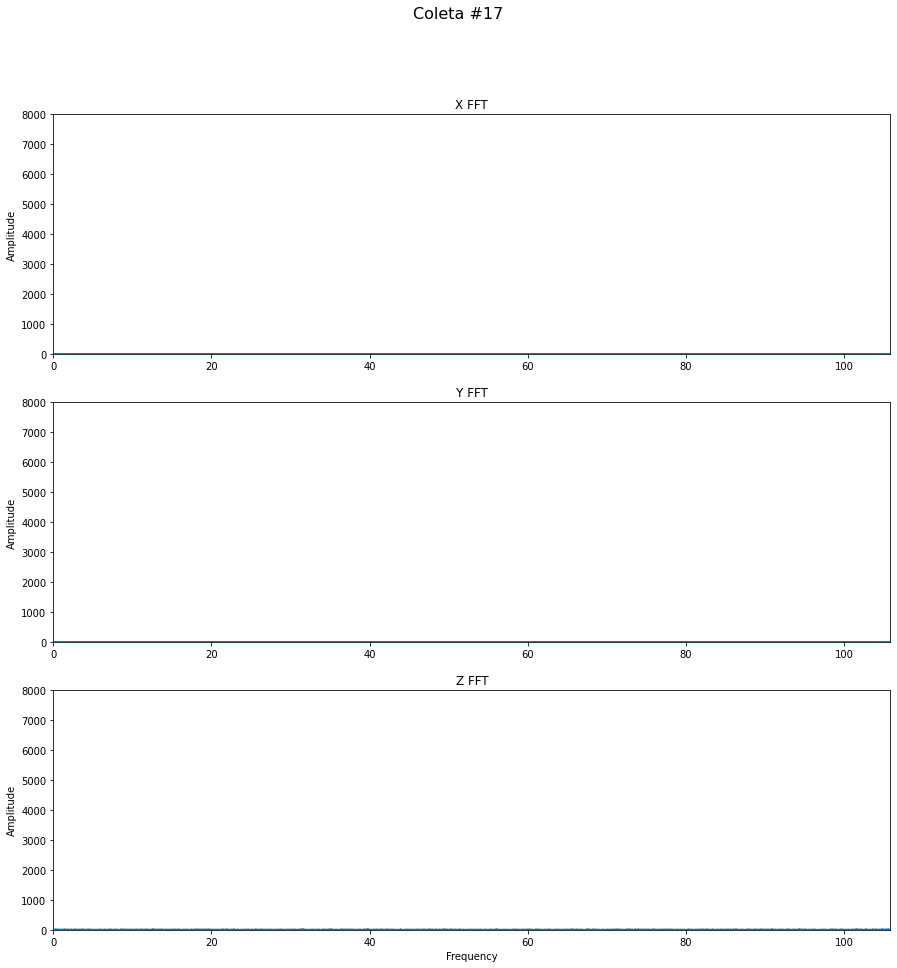

In [54]:
df,num = load_data(16)
plot_fft(df,num) 

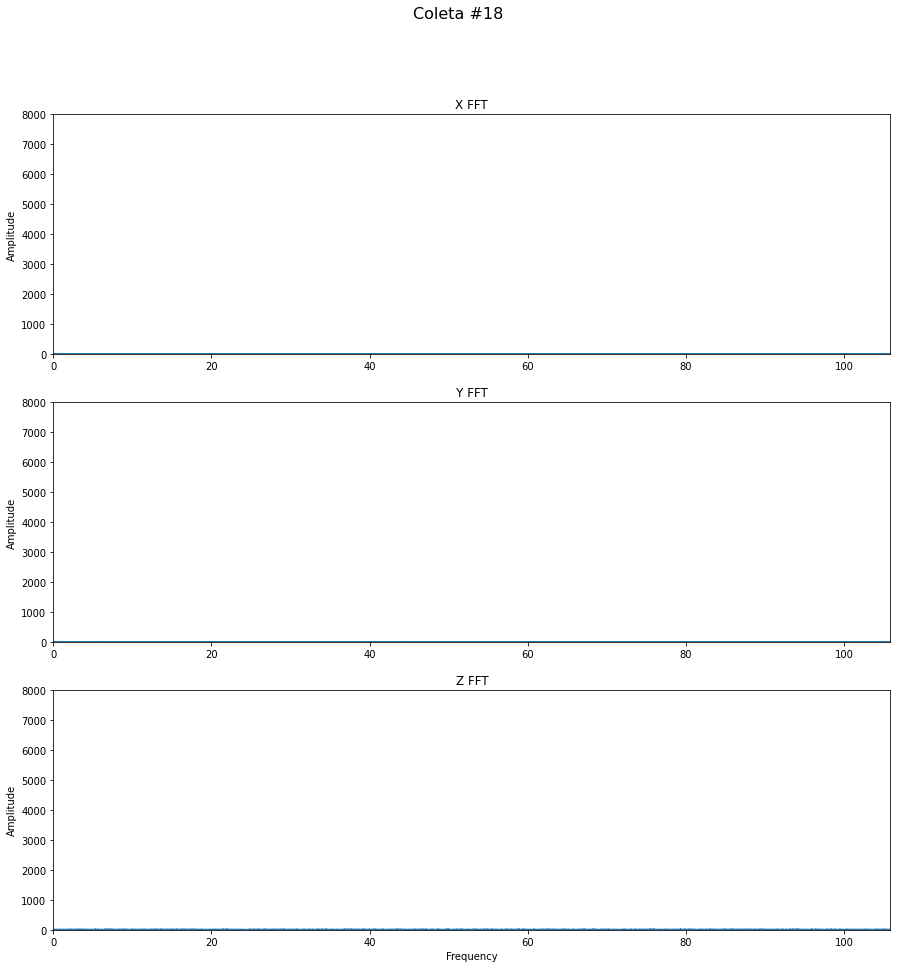

In [55]:
df,num = load_data(17)
plot_fft(df,num) 

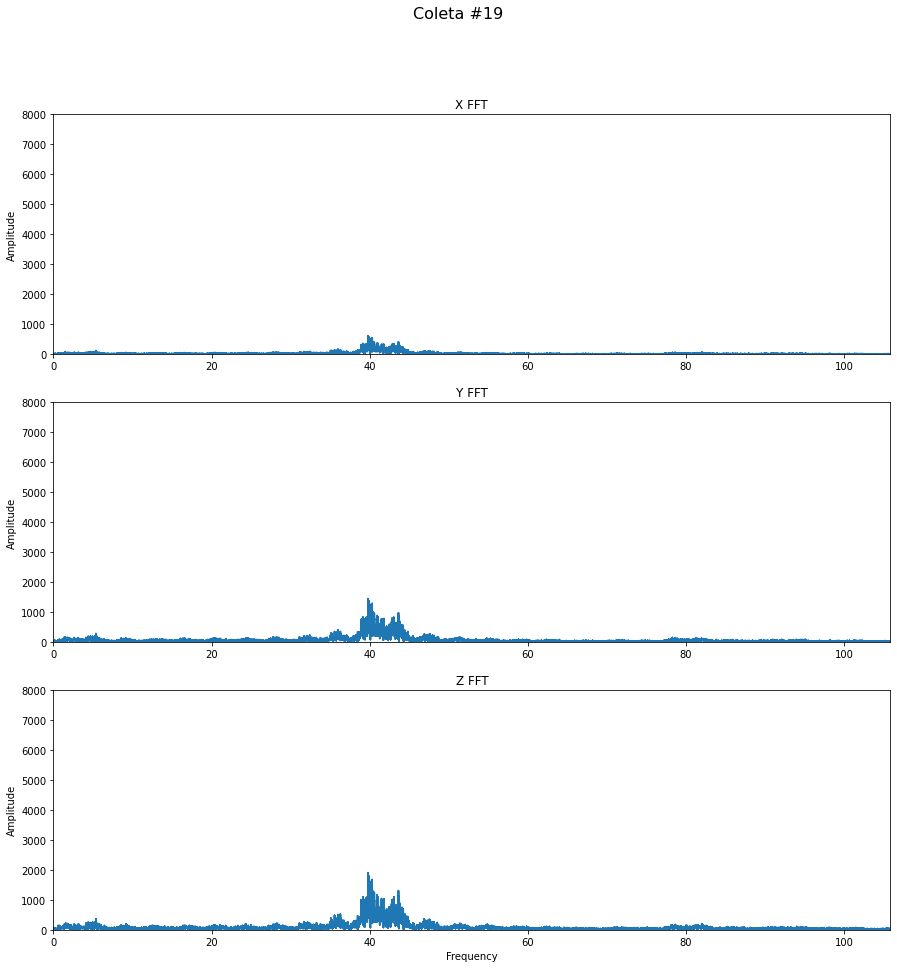

In [56]:
df,num = load_data(18)
plot_fft(df,num) 

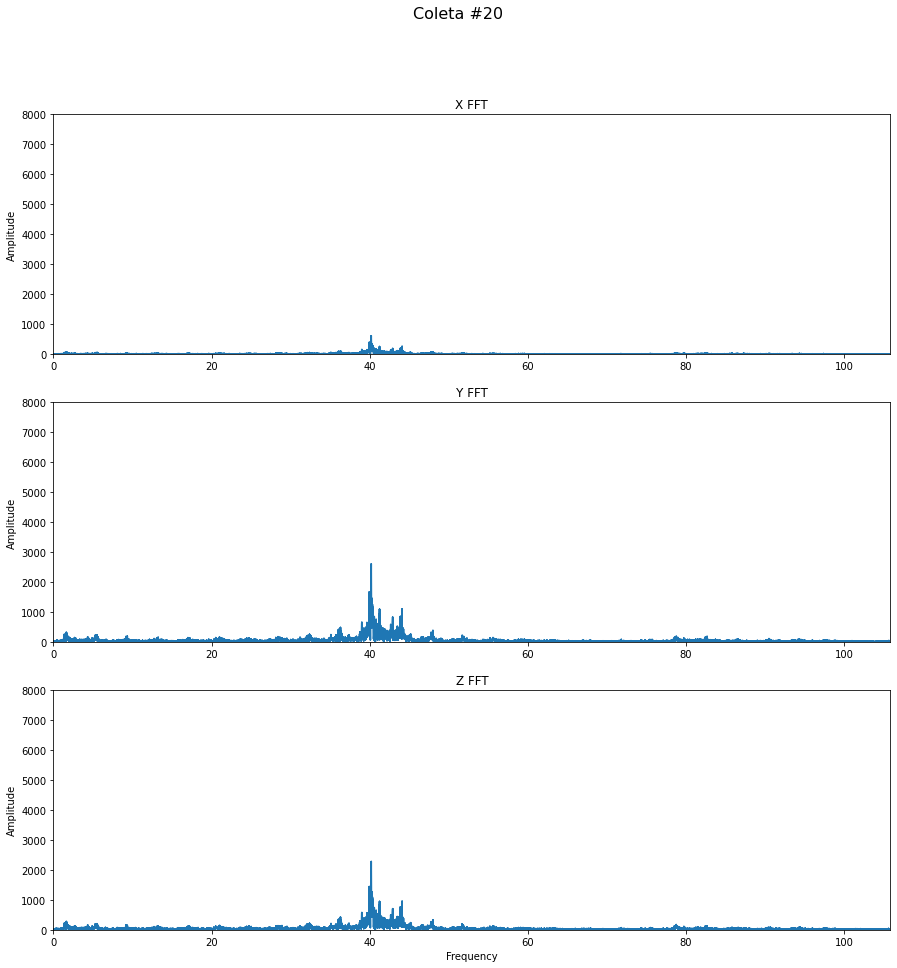

In [57]:
df,num = load_data(19)
plot_fft(df,num) 